In [3]:
import time
print(time.ctime(time.time()))

Mon Dec  8 14:32:58 2025


# Advent of Code Day 8

Puzzle text available at:
https://adventofcode.com/2025/day/8

In [4]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d
from scipy.spatial.distance import pdist, squareform
from PIL import Image
from tqdm.notebook import tqdm

In [5]:
# Day of calendar
day = 8
# Input filename
puzzle_test = 'input_day%02d_test.txt' %(day)
puzzle_input = 'input_day%02d.txt' %(day)

In [6]:
with open(puzzle_test, 'r') as f:
    coords = np.loadtxt(f, delimiter=',', dtype=int)
print(coords)

connections_limit = 1000

[[162 817 812]
 [ 57 618  57]
 [906 360 560]
 [592 479 940]
 [352 342 300]
 [466 668 158]
 [542  29 236]
 [431 825 988]
 [739 650 466]
 [ 52 470 668]
 [216 146 977]
 [819 987  18]
 [117 168 530]
 [805  96 715]
 [346 949 466]
 [970 615  88]
 [941 993 340]
 [862  61  35]
 [984  92 344]
 [425 690 689]]


## Part 1

Find the closest junction boxes and connect them

In [7]:
# Calculate pairwise distances between boxes using Scipy pdist
# Symmetric distance matrix
distance = squareform(pdist(coords))

# Set diagonal and lower triangle to NaN for visual purposes and avoid duplicate elements
distance[np.tril_indices_from(distance)] = np.nan

# Get upper triangle indices (excluding diagonal: k=1)
i_upper, j_upper = np.triu_indices(distance.shape[0], k=1)

# Get distances for upper triangle
upper_distances = distance[i_upper, j_upper]

# Sort by distance
sorted_idx = np.argsort(upper_distances)

# Get sorted (i,j) pairs and distances
sorted_pairs = list(zip(i_upper[sorted_idx], j_upper[sorted_idx]))

In [8]:
circuits = []

for i, pair in enumerate(sorted_pairs[:connections_limit]):
    # Solve manually first case
    if i == 0:   
        circuits.append(list(pair))
    else:
        # Find which circuits contain elements from pair
        matching_circuits = []
        for idx, connection in enumerate(circuits):
            if set(pair) & set(connection):
                matching_circuits.append(idx)
        
        if len(matching_circuits) == 0:
            # No overlap - create new circuit
            circuits.append(list(pair))
        elif len(matching_circuits) == 1:
            # One overlap - add box to that circuit
            common = set(pair) & set(circuits[matching_circuits[0]])
            if len(common) == 1:  # Avoid cycles
                circuits[matching_circuits[0]].extend(set(pair) - set(circuits[matching_circuits[0]]))
        else:
            # Multiple overlaps - MERGE circuits
            # Combine all matching circuits plus new pair
            merged = list(set(pair))
            for idx in sorted(matching_circuits, reverse=True):
                merged.extend(circuits[idx])
                circuits.pop(idx)  # Remove old circuit
            circuits.append(list(set(merged)))  # Add merged circuit (remove duplicates)

In [9]:
length_circuits = sorted([len(circuit) for circuit in circuits], reverse=True)
result_part1 = np.prod(length_circuits[:3])

In [10]:
print("what do you get if you multiply together the sizes of the three largest circuits?")
print(result_part1)

what do you get if you multiply together the sizes of the three largest circuits?
20


## Part 2

Continue connecting the closest unconnected pairs of junction boxes together until they're all in the same circuit. What do you get if you multiply together the X coordinates of the last two junction boxes you need to connect?

The first part of the problem is the same - calculate the distances between the pair of boxes

Now the condition to finish the loop is to have all of the boxes in circuit

In [11]:
circuits = []

for i, pair in enumerate(sorted_pairs):
    # Solve manually first case
    if i == 0:   
        circuits.append(list(pair))
    else:
        # Find which circuits contain elements from pair
        matching_circuits = []
        for idx, connection in enumerate(circuits):
            if set(pair) & set(connection):
                matching_circuits.append(idx)
        
        if len(matching_circuits) == 0:
            # No overlap - create new circuit
            circuits.append(list(pair))
        elif len(matching_circuits) == 1:
            # One overlap - add box to that circuit
            common = set(pair) & set(circuits[matching_circuits[0]])
            if len(common) == 1:  # Avoid cycles
                circuits[matching_circuits[0]].extend(set(pair) - set(circuits[matching_circuits[0]]))
        else:
            # Multiple overlaps - MERGE circuits
            # Combine all matching circuits plus new pair
            merged = list(set(pair))
            for idx in sorted(matching_circuits, reverse=True):
                merged.extend(circuits[idx])
                circuits.pop(idx)  # Remove old circuit
            circuits.append(list(set(merged)))  # Add merged circuit (remove duplicates)
    
    # Part 2 addition
    if len(circuits) == 1 and len(circuits[0]) == len(coords):
        result_part2 = coords[pair[0],0] * coords[pair[1],0]
        break

In [12]:
print("What do you get if you multiply together the X coordinates of the last two junction boxes you need to connect?")
print(result_part2)

What do you get if you multiply together the X coordinates of the last two junction boxes you need to connect?
25272


0it [00:00, ?it/s]

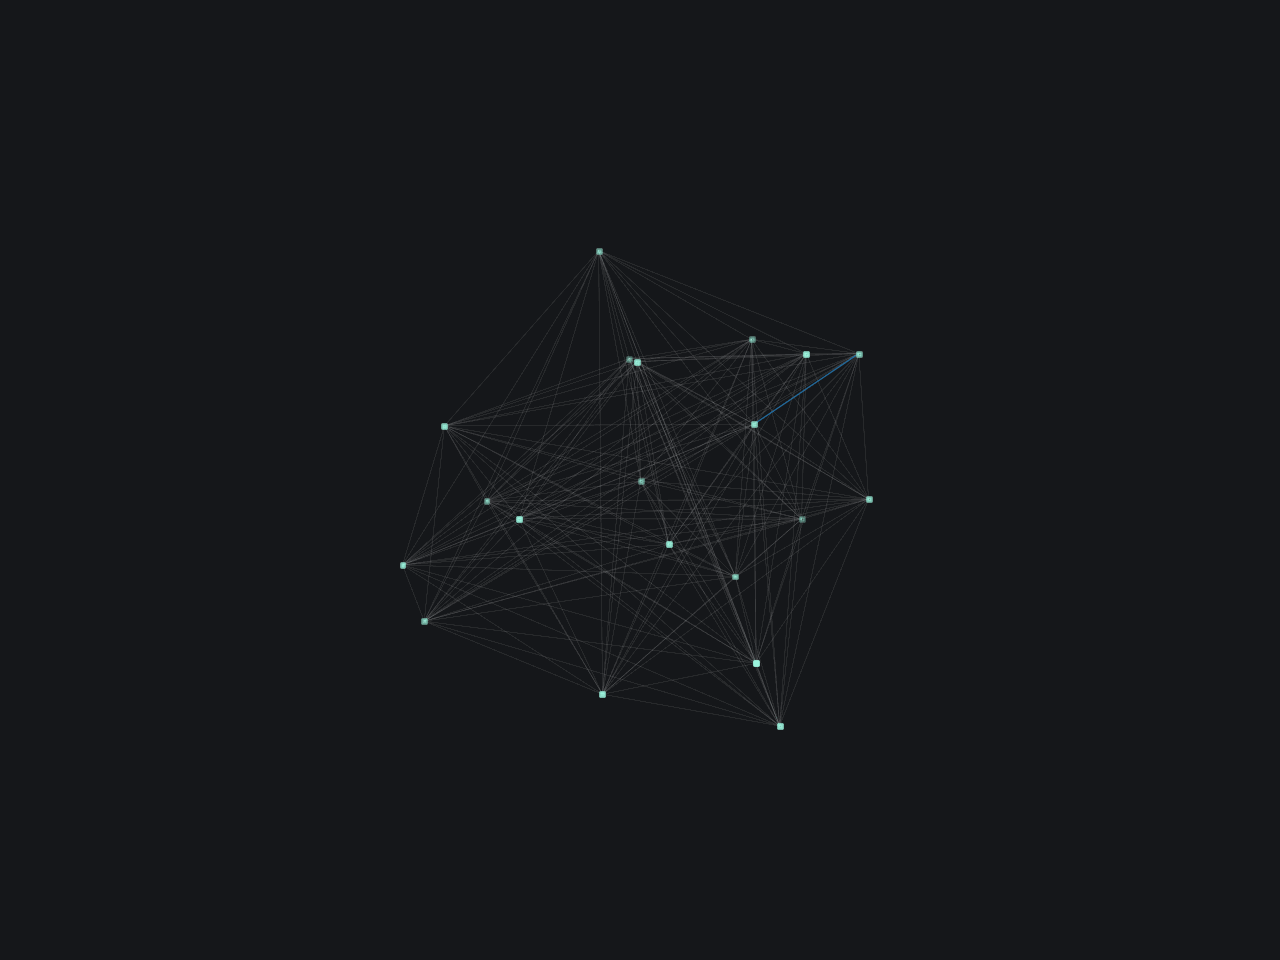

Part 2 result: 25272


In [37]:
# Var Init
circuits = []
frames = []
idx_frame = 0

# Build circuits and create animation frames
for i, pair in tqdm(enumerate(sorted_pairs)):
    
    # === Circuit Building Logic ===
    if i == 0:
        # First pair - create initial circuit
        circuits.append(list(pair))
    else:
        # Find which circuits contain elements from current pair
        matching_circuits = [
            idx for idx, connection in enumerate(circuits) 
            if set(pair) & set(connection)
        ]
        
        if len(matching_circuits) == 0:
            # No overlap - create new circuit
            circuits.append(list(pair))
            
        elif len(matching_circuits) == 1:
            # One circuit matches - add new box if not already present
            idx = matching_circuits[0]
            common = set(pair) & set(circuits[idx])
            if len(common) == 1:  # Avoid cycles
                circuits[idx].extend(set(pair) - set(circuits[idx]))
                
        else:
            # Multiple circuits match - merge them
            merged = list(set(pair))
            for idx in sorted(matching_circuits, reverse=True):
                merged.extend(circuits[idx])
                circuits.pop(idx)
            circuits.append(list(set(merged)))
    
    # === Plotting ===
    plt.close()
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, dpi=200)
    fig.set_facecolor('#15171A')
    ax.set_facecolor('#15171A')
    
    # Plot junction boxes
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
               c='#9BF7DF', s=2, marker='s')
    
    # Plot all possible connections (background)
    for point1, point2 in sorted_pairs:
        points = np.vstack([coords[point1], coords[point2]])
        ax.plot(points[:, 0], points[:, 1], points[:, 2], 
                'lightgray', alpha=0.2, lw=0.2)
    
    # Plot current circuits (highlighted)
    for circuit in circuits:
        points = np.vstack([coords[box] for box in circuit])
        ax.plot(points[:, 0], points[:, 1], points[:, 2], 
                alpha=0.8, lw=0.5)
    
    ax.set_axis_off()
    
    # === Create multiple frames per iteration for smooth rotation ===
    for k in range(4):
        ax.view_init(azim=30 + idx_frame * 0.5)
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frames.append(Image.open(buf).copy())
        buf.close()
        
        idx_frame += 1
    
    
    # === Check completion ===
    if len(circuits) == 1 and len(circuits[0]) == len(coords):
        result_part2 = coords[pair[0], 0] * coords[pair[1], 0]
        break

# === Final rotation frames ===
for j in range(70):
    ax.view_init(azim=30 + idx_frame * 0.5)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    frames.append(Image.open(buf).copy())
    buf.close()
    
    idx_frame += 1

plt.close()

# === Save GIF ===
fname = 'aoc2025_day08_part2.gif'
frames[0].save(
    fname, 
    save_all=True, 
    append_images=frames[1:], 
    duration=35,
    loop=0
)

# Display result
from IPython.display import Image as IPImage, display
display(IPImage(filename=fname))
print(f"Part 2 result: {result_part2}")

In [38]:
matching_circuits

[0]

The connections are not correcct in fact, as it is plotting just in order of the circuit

Is that the closest, not right? Will have to think about thiss

In [43]:
# Var Init
circuits = []
frames = []
idx_frame = 0

# Build circuits and create animation frames
for i, pair in tqdm(enumerate(sorted_pairs)):
    
    # === Circuit Building Logic ===
    if i == 0:
        # First pair - create initial circuit
        circuits.append(list(pair))
    else:
        # Find which circuits contain elements from current pair
        matching_circuits = [
            idx for idx, connection in enumerate(circuits) 
            if set(pair) & set(connection)
        ]
        
        if len(matching_circuits) == 0:
            # No overlap - create new circuit
            circuits.append(list(pair))
            
        elif len(matching_circuits) == 1:
            # One circuit matches - add new box if not already present
            idx = matching_circuits[0]
            common = set(pair) & set(circuits[idx])
            if len(common) == 1:  # Avoid cycles
                circuits[idx].extend(set(pair) - set(circuits[idx]))
                
        else:
            # Multiple circuits match - merge them
            merged = list(set(pair))
            for idx in sorted(matching_circuits, reverse=True):
                merged.extend(circuits[idx])
                circuits.pop(idx)
            circuits.append(list(set(merged)))
    

    print(coords[pair[0]], coords[pair[1]])
    print(matching_circuits)
    
    # === Check completion ===
    if len(circuits) == 1 and len(circuits[0]) == len(coords):
        result_part2 = coords[pair[0], 0] * coords[pair[1], 0]
        print(i,result_part2)
        break


0it [00:00, ?it/s]

[162 817 812] [425 690 689]
[0]
[162 817 812] [431 825 988]
[0]
[906 360 560] [805  96 715]
[]
[431 825 988] [425 690 689]
[0]
[862  61  35] [984  92 344]
[]
[ 52 470 668] [117 168 530]
[]
[819 987  18] [941 993 340]
[]
[906 360 560] [739 650 466]
[1]
[346 949 466] [425 690 689]
[0]
[906 360 560] [984  92 344]
[1, 2]
[592 479 940] [425 690 689]
[0]
[352 342 300] [542  29 236]
[]
[352 342 300] [117 168 530]
[1, 4]
[352 342 300] [466 668 158]
[3]
[542  29 236] [862  61  35]
[2, 3]
[592 479 940] [431 825 988]
[0]
[739 650 466] [425 690 689]
[0, 2]
[162 817 812] [ 52 470 668]
[1]
[819 987  18] [970 615  88]
[0]
[805  96 715] [984  92 344]
[1]
[466 668 158] [739 650 466]
[1]
[162 817 812] [346 949 466]
[1]
[739 650 466] [941 993 340]
[0, 1]
[ 57 618  57] [466 668 158]
[0]
[ 52 470 668] [425 690 689]
[0]
[466 668 158] [346 949 466]
[0]
[739 650 466] [970 615  88]
[0]
[970 615  88] [941 993 340]
[0]
[216 146 977] [117 168 530]
[0]
28 25272
